# Creating a gold standard from existing Taboo cards

## Reading in and formatting the cards

The Taboo cards that our gold standard will be based on belong to Elizabeth's Canadian edition of Taboo, produced sometime in the 1990s or early 2000s.

In [2]:
FILENAME = "taboo_cards.txt"


def read_in(filename):
    """
    Reads in transcribed Taboo card words contained in the given file and returns them in an enumerated list.
    """
    file_lines = []
    
    with open(filename, "r", encoding='utf-8') as myfile:
        
        # Go through every line, saving non-empty ones to the list file_lines.
        for line in myfile:
            if line.strip() != '':             
                file_lines.append(line.strip()) 
                
    return list(enumerate(file_lines))
    
            
def format_cards(enum_list):
    """
    Given an enumerated list (output of read_in()), formats the contents as a dictionary (key = MW, values = list of TWs)
    """
    
    # Initialise dictionary to contain card data.
    card_dict = dict()
    
    # Assign MWs (every sixth word in the enumerated list) as dictionary keys, and create a list for the dict's
    # value consisting of the five following words (the TWs); the word[1:] removes the dash from the beginning of
    # each TW's string.

    for enum, wd in enum_list:
        if enum % 6 == 0:
            card_dict[wd] = [word[1:] for num, word in enum_list[enum+1:enum+6]]
        
    return card_dict
        

enum_lines = read_in(FILENAME)
cards = format_cards(enum_lines)

In [3]:
# Example: the five TWs from the MW 'syrup'
cards['syrup']

['maple', 'pancakes', 'trees', 'sap', 'sweet']

In [4]:
len(cards)

240

In addition to this dictionary format, it will be helpful to set up a pandas dataframe for easy addition of columns for semantic similarity and corpus-based collocation measures below.

In [5]:
import pandas as pd
import numpy as np

In [6]:
# Create a pandas dataframe quickly based on a list of dictionaries, with each dictionary corresponding to a row in the 
# dataframe.
# ( Source: https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/17496530#17496530 )

rows_list = []

for mainwd, tabwds in cards.items():
    for tabwd in tabwds:
        
        # Create a dictionary for each row of the dataframe (key = column name, value = row value for that column)
        row = {
            'mw': mainwd,
            'tw': tabwd
        }
        
        # Append to rows_list, and use that list as a basis for the new dataframe.
        rows_list.append(row)

data = pd.DataFrame(rows_list)
data.head()

,mw,tw
0,huddle,gather
1,huddle,football
2,huddle,group
3,huddle,play
4,huddle,together


In [7]:
# Export dataframe to csv for manual annotation
#data.to_csv(r'gold-std-raw.csv', index=False, encoding='utf-8')

In [89]:
# After manual annotation, read the csv back in and save as pandas dataframe, replacing NaNs with 0.
# (30.1.20: Currently working on a smaller development version with just 15 annotated lines)

gs_df = pd.read_csv('gold-std-ep-dev.csv')
gs_df.fillna(0,inplace=True)
gs_df.head()

,mw,tw,semrel_synonym,semrel_antonym,semrel_hyponym,semrel_hypernym,collocation,cultural_ref,other
0,huddle,gather,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,huddle,football,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,huddle,group,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,huddle,play,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,huddle,together,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Count and plot the number of categories appearing in the dataset

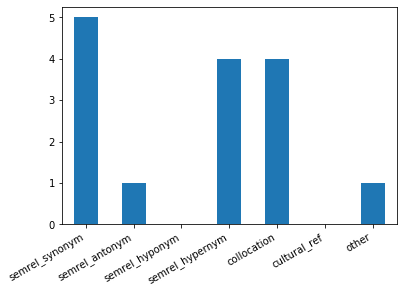

In [90]:
# Get the sum of each column as a series.
gs_df_sum = gs_df.loc[:, 'semrel_synonym':'other'].sum()

# Create a bar plot object out of it.
# (Plot y axis labels as integers by creating a list of integers based on the y range)
yint = [x for x in range( int(gs_df_sum.max()) + 1 )]
gs_df_sum_plot = gs_df_sum.plot.bar(x='category', y='count', yticks=yint)

# For readable x axis tick labels, set their rotation angle to 30 and the horizontal alignment to right.
gs_df_sum_plot.set_xticklabels(gs_df_sum_plot.get_xticklabels(), rotation=30, horizontalalignment='right');

## Computing semantic similarity with gensim

In [76]:
import gensim

# The following line of code requires that the large word embeddings file is in the current directory (not set up on
# GitHub because it is too large to push around nicely, so for replication, have to add this file manually).
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

### A SOBERING REALISATION

- In the end, what follows (computing semantic similarity for the collocates) might be interesting as a curiosity, but probably can't actually be used in generating the Taboo cards, because we can't search for words whose similarities fall into a given range using gensim (it's only possible to go the other way, from words to similarities, not from similarities to words)

In [220]:
def add_similarity_to_df(df):
    """
    Computes the similarity between the MW in the first column and the TW in the second of the passed-in dataframe,
    when the TW is flagged in the column collocation.
    
    Args:
        df: dataframe containing cleaned corpus data
        
    Returns:
        A dataframe with a new column 'simil' containing word2vec similarity values for all words classified as collocations.
    """
    
    # Initialise empty list to collect similarity values as we go.
    simil_col=[]
    
    # Iterate through rows in the dataframe.
    for row_idx in range(len(df)):
        
        # Check if the value in the collocation column is 1.
        if df.loc[row_idx, ['collocation']][0] == 1:
        
            # Get the MW and the TW in the current row.
            mw = df.loc[row_idx, ['mw']][0]
            tw = df.loc[row_idx, ['tw']][0]

            # KeyError raised if word not in the word2vec vocabulary, so if that happens, add numpy's null value
            # to the column instead.
            try:
                value = model.similarity(mw, tw)
            except KeyError:
                value = np.nan
        
        else:
            value = np.nan
        
        # Add similarity value to the list. At the end, this list will be of the same length
        # as the dataframe and will contain a similarity value (or NaN) for each adjective pair.
        simil_col.append(value)
    
    # Add this list as a new column to the dataframe and return dataframe.
    df['simil'] = simil_col
    
    return df


gs_df = add_similarity_to_df(gs_df)
gs_df

,mw,tw,semrel_synonym,semrel_antonym,semrel_hyponym,semrel_hypernym,collocation,cultural_ref,other,simil
0,huddle,gather,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
1,huddle,football,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.314302
2,huddle,group,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
3,huddle,play,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.299363
4,huddle,together,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.256514
5,croak,frog,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.365087
6,croak,die,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7,croak,kick,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
8,croak,sound,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
9,croak,noise,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN


In [221]:
# For example
gs_df[gs_df['mw'] == 'huddle']

,mw,tw,semrel_synonym,semrel_antonym,semrel_hyponym,semrel_hypernym,collocation,cultural_ref,other,simil
0,huddle,gather,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
1,huddle,football,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.314302
2,huddle,group,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
3,huddle,play,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.299363
4,huddle,together,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.256514


### Describing the semantic similarity results

In [222]:
# We can look at how the data are distributed.
# First make a dataframe from only the similarity column, for easier plotting.

simil_df = pd.DataFrame(gs_df['simil'])
simil_df.describe()

,simil
count,4.000000
mean,0.308816
std,0.044801
min,0.256514
25%,0.288651
50%,0.306832
75%,0.326998
max,0.365087


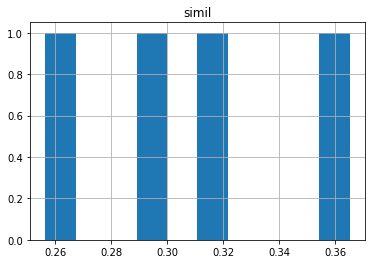

In [223]:
simil_df.hist();

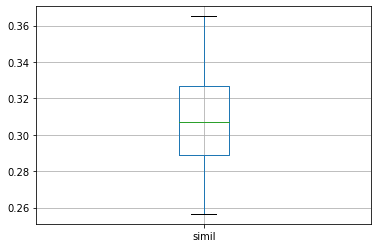

In [224]:
simil_df.boxplot();

### SAD BRAINSTORM

- One idea was to treat the distribution of semantic similarity values like a Bayesian posterior, and then draw samples from it proportional to its density and try to find words within the given range of similarity to the MW
- **Problem with that: can't return words by their vector similarity;** you need the words first to compute the similarity values.
- So, maybe better just to rely on the classification for rough proportions of how much of each type of relation to the MW should go into the pool to choose from, and then just pick from the most similar words from `model.most_similar()`

In [114]:
model.most_similar('cat')

[('cats', 0.8099379539489746),
 ('dog', 0.7609457969665527),
 ('kitten', 0.7464984655380249),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150583267211914),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931377410889),
 ('chihuahua', 0.6709762215614319)]

## WordNet semantic relations

This bit worked well! Using WordNet, I created dictionaries for a given input word that contain all of that word's synonyms, antonyms, hypernyms, and hyponyms :) 

In [116]:
from nltk.corpus import wordnet as wn

In [276]:
def word_to_synsets(word):
    """
    Converts the given word to a synset object.
    
    Arg:
        word: a string like 'cat'
        pos: the desired part of speech (choices: wn.NOUN, wn.VERB, wn.ADJ, wn.ADV)
    Returns:
        A string containing the first synset ID, formatted according to WordNet's conventions, e.g. 'cat.n.01',
        corresponding to that word.
    """
    # Convert word string to the synset with the corresponding part of speech.
    return wn.synsets(word)
    

def synset_to_word(synset):
    """
    Converts the given synset to the actual word it represents.
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A string containing the word corresponding to that synset.
    """   
    # Convert synset to lemma, since this is what name() is defined over.
    return synset.lemmas()[0].name()


def get_antonyms(synset):
    """
    Returns all antonyms for the given synset.
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of antonymic words as strings, if there are any, or else the empty list.
    """    
    # Convert synset to lemma, since this is what the antonym relation is defined over, and get antonym(s).
    ant_lemmas = synset.lemmas()[0].antonyms()
    
    # Convert each antonym in this list to a string and return list (empty if no antonyms).
    return [ant_lemma.name() for ant_lemma in ant_lemmas]


def get_hypernyms(synset):
    """
    Returns all immediate hypernyms for the given synset.
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of hypernymic words as strings.
    """
    # Convert hypernyms of the synset to strings and return list.
    return [synset_to_word(hyper) for hyper in synset.hypernyms()]


def get_hyponyms(synset):
    """
    Returns all immediate hyponyms for the given synset. (There are often many.)
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of hyponymic words as strings.
    """
    # Convert hypernyms of the synset to strings and return list.
    return [synset_to_word(hypo) for hypo in synset.hyponyms()]


def get_synonyms(word):
    """
    Returns a set of synonyms, according to WordNet, for the given input word (using all of its senses, if
    there are multiple).
    
    Arg:
        word: a string representing the word whose synonyms we want.
    Returns:
        A set containing all of the other words in the same WordNet synset as the given word.
    """
    # Initialise set that will collect the synonyms.
    synonym_set = set()
    
    # Convert the word to a list of synsets.
    synset_list = word_to_synsets(word)

    # Get all the lemmas corresponding to the given word's synset.
    synonym_lems = [x.lemmas() for x in synset_list]
    
    # Go through them, get the names from the lemma (lowercasing everything for consistency), and add
    # to synonym_set.
    for lemma_list in synonym_lems:
        syn = lemma_list[0].name().lower()
        synonym_set.update( [syn] )

    # Return the synonym set with the input word removed.
    return synonym_set.difference({word})


def make_semrel_dict(word):
    """
    Arg:
        word: a string like 'cat'
        pos: the desired part of speech (choices: wn.NOUN, wn.VERB, wn.ADJ, wn.ADV)
    Returns:
        A dictionary with the semantic relations as keys and a set of words that have that relation to all senses
        of the input word, according to WordNet, as values.
    """
    
    # Initialise dictionary (and we can get synonyms right away).
    semrel_dict = {
        'synonym': get_synonyms(word),
        'antonym': set(),
        'hypernym': set(),
        'hyponym': set()
    }
    
    # Convert the input word to all of its synsets.
    ss = word_to_synsets(word)
    
    # Go through each synset, determining its antonyms, hypernyms, and hyponyms, and adding each to the set in the
    # appropriate entry of the dictionary.
    for s in ss:
        semrel_dict['antonym'].update( get_antonyms(s) )
        semrel_dict['hypernym'].update( get_hypernyms(s) )
        semrel_dict['hyponym'].update( get_hyponyms(s) )
        
    return semrel_dict

In [282]:
make_semrel_dict('flower')

{'synonym': {'bloom'},
 'antonym': set(),
 'hypernym': {'angiosperm',
  'develop',
  'reproductive_structure',
  'time_period'},
 'hyponym': {'African_daisy',
  'African_violet',
  'Carolina_spring_beauty',
  'China_aster',
  'Christmas_bells',
  'Easter_daisy',
  'Malcolm_stock',
  'Mexican_sunflower',
  'Swan_River_daisy',
  'Texas_star',
  'Virginia_spring_beauty',
  'Virginian_stock',
  'achimenes',
  'ageratum',
  'ammobium',
  'anemone',
  'apetalous_flower',
  'aster',
  "baby's_breath",
  'bartonia',
  'begonia',
  'bellwort',
  'billy_buttons',
  'blazing_star',
  'bloomer',
  'blue-eyed_African_daisy',
  'blue_daisy',
  'brass_buttons',
  'bud',
  'bush_violet',
  'butterfly_flower',
  'calceolaria',
  'calendula',
  'calla_lily',
  'candytuft',
  'cape_marigold',
  'catananche',
  'centaury',
  'chrysanthemum',
  'cineraria',
  'columbine',
  'commelina',
  'composite',
  'coneflower',
  'coral_drops',
  'cornflower',
  'corydalis',
  'cosmos',
  'cotton_rose',
  'cowherb',


In [285]:
make_semrel_dict('good')

{'synonym': {'adept',
  'beneficial',
  'commodity',
  'dear',
  'dependable',
  'effective',
  'estimable',
  'full',
  'thoroughly',
  'well'},
 'antonym': {'bad', 'evil', 'ill'},
 'hypernym': {'advantage', 'artifact', 'morality', 'quality'},
 'hyponym': {'basic',
  'beneficence',
  'benefit',
  'benignity',
  'better',
  'common_good',
  'consumer_goods',
  'desirability',
  'drygoods',
  'entrant',
  'export',
  'fancy_goods',
  'fungible',
  'future',
  'import',
  'kindness',
  'merchandise',
  'middling',
  'optimum',
  'saintliness',
  'salvage',
  'shopping',
  'sporting_goods',
  'summum_bonum',
  'virtue',
  'wisdom',
  'worldly_possession',
  'worthiness'}}

In [286]:
make_semrel_dict('think')

{'synonym': {'intend', 'remember'},
 'antonym': {'forget'},
 'hypernym': {'change',
  'concentrate',
  'deliberation',
  'evaluate',
  'expect',
  'imagine',
  'think'},
 'hyponym': {'aim',
  'associate',
  'brainstorm',
  'chew_over',
  'concentrate',
  'design',
  'evaluate',
  'feel',
  'give',
  'hold',
  'know',
  'philosophize',
  'plan',
  'puzzle_over',
  'rationalize',
  'reason',
  'recognize',
  'rethink',
  'review',
  'see',
  'study',
  'suspect',
  'think',
  'think_about',
  'think_of'}}

## Postprocessing / things to deal with

- when WordNet and `model.most_similar()` return the same word -- remove duplicate or somehow weight it double?
- will need to remove instances of the MW and words that are also morphologically related to it -- probably do this in one sweep at the end